# Volterra（沃尔泰拉）积分方程

## 小组及选题介绍

​**小组信息**​  
- ​**小组序号**​：86  
- ​**小组名称**​：小时不识月，呼作地卫一  
- ​**成员组成**​：王梓宇（组长）、刘翰坤  

​**选题信息**​  
- ​**选题序号**​：55  
- ​**选题名称**​：DeepXDE: A Deep Learning Library for Solving Differential Equations  

​**选题说明**​  
DeepXDE 是一个基于深度学习的微分方程求解库，主要特点包括：  
• 支持PDE/ODE/积分方程等多种方程类型  
• 实现物理信息神经网络（PINNs）  
• 灵活的边界条件处理机制  
• 多GPU并行计算支持  

典型应用场景：复杂物理系统建模、工程优化、科学计算中的逆问题研究，以及与传统数值方法的协同应用。

## 0. 环境准备

In [6]:
# 安装最新 develop 版 PaddlePaddle
!pip uninstall paddlepaddle-gpu -y
!python -m pip install paddlepaddle-gpu==0.0.0.post118 -f https://www.paddlepaddle.org.cn/whl/linux/gpu/develop.html -i https://mirrors.aliyun.com/pypi/simple/ 

# 下载并安装 PaddleScience
%cd /home/aistudio/work
!git clone https://gitee.com/paddlepaddle/PaddleScience.git
%cd /home/aistudio/work/PaddleScience
!git checkout develop
# 拉取最新代码
!git pull
!git log -1
!pip install -e . -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install protobuf==3.20.3 -i https://pypi.tuna.tsinghua.edu.cn/simple

Found existing installation: paddlepaddle-gpu 0.0.0.post118
Uninstalling paddlepaddle-gpu-0.0.0.post118:
  Successfully uninstalled paddlepaddle-gpu-0.0.0.post118
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
Looking in links: https://www.paddlepaddle.org.cn/whl/linux/gpu/develop.html
  Using cached https://paddle-wheel.bj.bcebos.com/develop/linux/linux-gpu-cuda11.8-cudnn8.6-mkl-gcc8.2-avx/paddlepaddle_gpu-0.0.0.post118-cp310-cp310-linux_x86_64.whl (726.9 MB)
/home/aistudio/work
fatal: destination path 'PaddleScience' already exists and is not an empty directory.
/home/aistudio/work/PaddleScience
Already on 'develop'
Your branch is up to date with 'origin/develop'.
Already up to date.
commit e0f02450a05e9391f520f59d127c856294e547c6 (HEAD -> develop, origin/develop, origin/HEAD)
Author: HydrogenSulfate <490868991@qq.com>
Date:   Mon Jun 9 11:50:41 2025 +0800

    Update README.md
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn

In [7]:
!python -c "import paddle; paddle.version.show()"

commit: f41f081861203441adf3f235bfa854c6fd312d1d
cuda: 11.8
cudnn: 8.6.0
nccl: 21602
xpu_xre: False
xpu_xccl: False
xpu_xhpc: False
cinn: 0.3.0


In [8]:
from typing import Tuple, Dict

## 问题简介

Volterra integral equation(沃尔泰拉积分方程)是一种积分方程，即方程中含有对待求解函数的积分运算，其有两种形式，如下所示

$$
\begin{aligned}
  f(t) &= \int_a^t K(t, s) x(s) d s \\
  x(t) &= f(t)+\int_a^t K(t, s) x(s) d s
\end{aligned}
$$

在本次作业中，我们将复现官方示例，并搜索了额外四个沃尔泰拉积分方程问题，进行编码求解


## 官方示例
在该小节中，我们对官方提供的一个实例进行了复现

### 1. 问题定义

假设存在如下 IDE 方程：

$$
u(t) = -\dfrac{du}{dt} + \int_{t_0}^t e^{t-s} u(s) d s
$$

其中 $u(t)$ 就是待求解的函数，而 $-\dfrac{du}{dt}$ 对应了 $f(t)$，$e^{t-s}$ 对应了 $K(t,s)$。
因此可以利用神经网络模型，以 $t$ 为输入，$u(t)$ 为输出，根据上述方程构建微分约束，进行无监督学习最终拟合出待求解的函数 $u(t)$。

为了方便在计算机中进行求解，我们将上式进行移项，让积分项作为左侧，非积分项移动到右侧，如下所示：

$$
\int_{t_0}^t e^{t-s} u(s) d s = u(t) + \dfrac{du}{dt}
$$


### 2. 问题求解

接下来开始讲解如何将问题一步一步地转化为 PaddleScience 代码，用深度学习的方法求解该问题。
为了快速理解 PaddleScience，接下来仅对模型构建、方程构建、计算域构建等关键步骤进行阐述，而其余细节请参考 [API文档](https://paddlescience-docs.readthedocs.io/zh/latest/zh/api/arch/)。



In [9]:
# 引入必要模块
from typing import Dict

import numpy as np
import paddle
from matplotlib import pyplot as plt

import ppsci
from ppsci.autodiff import jacobian
from ppsci.utils import config
from ppsci.utils import logger

# set random seed for reproducibility
ppsci.utils.misc.set_random_seed(42)

# set output directory
OUTPUT_DIR = "./output_Volterra_IDE"
logger.init_logger("ppsci", f"{OUTPUT_DIR}/train.log", "info")

### 3.1 模型构建

在上述问题中，我们确定了输入为 $t$，输出为 $u(t)$，因此我们使用，用 PaddleScience 代码表示如下：


In [10]:
# set model
model = ppsci.arch.MLP(("x",), ("u",), 3, 20)

W0609 16:03:57.317126  2605 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0609 16:03:57.318248  2605 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


### 3.2 计算域构建

Volterra_IDE 问题的积分域是 $a$ ~ $t$，其中 `a` 为固定常数 0，`t` 的范围为 0 ~ 5，因此可以使用PaddleScience 内置的一维几何 `TimeDomain` 作为计算域。



In [11]:
# set geometry
BOUNDS = (0, 5)
geom = {"timedomain": ppsci.geometry.TimeDomain(BOUNDS[0], BOUNDS[1])}

为了在计算时，准确快速地访问具体变量的值，我们在这里指定网络模型的输入变量名是 `"x"`，输出变量名是 `"u"`，接着通过指定 `MLP` 的隐藏层层数、神经元个数，我们就实例化出了神经网络模型 `model`。


### 3.3 方程构建

由于 Volterra_IDE 使用的是积分方程，因此可以直接使用 PaddleScience 内置的 `ppsci.equation.Volterra`，并指定所需的参数：积分下限 `a`、`t` 的离散取值点数 `num_points`、一维高斯积分点的个数 `quad_deg`、$K(t,s)$ 核函数 `kernel_func`、$u(t) - f(t)$ 等式右侧表达式 `func`。


In [12]:
# set equation
QUAD_DEG = 20
NPOINT_INTERIOR = 12
NPOINT_IC = 1

def kernel_func(x, s):
    return np.exp(s - x)

def func(out):
    x, u = out["x"], out["u"]
    return jacobian(u, x) + u

equation = {
    "volterra": ppsci.equation.Volterra(
        BOUNDS[0],
        NPOINT_INTERIOR,
        QUAD_DEG,
        kernel_func,
        func,
    )
}


### 3.4 约束构建


#### 3.4.1 内部点约束
本文采用无监督学习的方式，对移项后方程的左、右两侧进行约束，让其尽量相等。

由于等式左侧涉及到积分计算（实际采用高斯积分近似计算），因此在 0 ~ 5 区间内采样出多个 `t_i` 点后，还需要计算其用于高斯积分的点集，即对每一个 `(0,t_i)` 区间，都计算出一一对应的高斯积分点集 `quad_i` 和点权 `weight_i`。PaddleScience 将这一步作为输入数据的预处理，加入到代码中，如下所示


In [24]:
QUAD_DEG = 20
NPOINT_INTERIOR = 12
NPOINT_IC = 1

def input_data_quad_transform(
    input: Dict[str, np.ndarray],
    weight: Dict[str, np.ndarray],
    label: Dict[str, np.ndarray],
) -> Tuple[
    Dict[str, paddle.Tensor], Dict[str, paddle.Tensor], Dict[str, paddle.Tensor]
]:
    """Get sampling points for integral.

    Args:
        input (Dict[str, paddle.Tensor]): Raw input dict.
        weight (Dict[str, paddle.Tensor]): Raw weight dict.
        label (Dict[str, paddle.Tensor]): Raw label dict.

    Returns:
        Tuple[ Dict[str, paddle.Tensor], Dict[str, paddle.Tensor], Dict[str, paddle.Tensor] ]:
            Input dict contained sampling points, weight dict and label dict.
    """
    x = input["x"]  # N points.
    x_quad = equation["volterra"].get_quad_points(x).reshape([-1, 1])  # NxQ
    x_quad = paddle.concat((x, x_quad), axis=0)  # M+MxQ: [M|Q1|Q2,...,QM|]
    return (
        {
            **input,
            "x": x_quad,
        },
        weight,
        label,
    )

# interior constraint
ide_constraint = ppsci.constraint.InteriorConstraint(
    equation["volterra"].equations,
    {"volterra": 0},
    geom["timedomain"],
    {
        "dataset": {
            "name": "IterableNamedArrayDataset",
            "transforms": (
                {
                    "FunctionalTransform": {
                        "transform_func": input_data_quad_transform,
                    },
                },
            ),
        },
        "batch_size": NPOINT_INTERIOR,
        "iters_per_epoch": ITERS_PER_EPOCH,
    },
    ppsci.loss.MSELoss("mean"),
    evenly=True,
    name="EQ",
)

#### 3.4.2 初值约束

在 $t=0$ 时，有以下初值条件：

$$
u(0) = e^{-t} \cosh(t)|_{t=0} = e^{0} \cosh(0) = 1
$$

因此可以加入 `t=0` 时的初值条件，代码如下所示


In [25]:
# initial condition
def u_solution_func(in_):
    if isinstance(in_["x"], paddle.Tensor):
        return paddle.exp(-in_["x"]) * paddle.cosh(in_["x"])
    return np.exp(-in_["x"]) * np.cosh(in_["x"])

ic = ppsci.constraint.BoundaryConstraint(
    {"u": lambda out: out["u"]},
    {"u": u_solution_func},
    geom["timedomain"],
    {
        "dataset": {"name": "IterableNamedArrayDataset"},
        "batch_size": NPOINT_IC,
        "iters_per_epoch": ITERS_PER_EPOCH,
    },
    ppsci.loss.MSELoss("mean"),
    criteria=geom["timedomain"].on_initial,
    name="IC",
)


在微分方程约束、初值约束构建完毕之后，以我们刚才的命名为关键字，封装到一个字典中，方便后续访问。


In [26]:
# wrap constraints together
constraint = {
    ide_constraint.name: ide_constraint,
    ic.name: ic,
}

### 3.5 超参数设定

接下来我们需要指定训练轮数和学习率，此处我们按实验经验，让 `L-BFGS` 优化器进行一轮优化即可，但一轮优化内的 `max_iters` 数可以设置为一个较大的一个数 `15000`。



In [27]:
# set training hyper-parameters
EPOCHS = 1

### 3.6 优化器构建

训练过程会调用优化器来更新模型参数，此处选择较为常用的 `LBFGS` 优化器。


In [28]:
# set optimizer
optimizer = ppsci.optimizer.LBFGS(
    learning_rate=1,
    max_iter=15000,
    max_eval=1250,
    tolerance_grad=1e-8,
    tolerance_change=0,
    history_size=100,
)(model)

### 3.7 评估器构建

在训练过程中通常会按一定轮数间隔，用验证集（测试集）评估当前模型的训练情况，因此使用 `ppsci.validate.GeometryValidator` 构建评估器。


In [29]:
# set validator
NPOINT_EVAL = 100
l2rel_validator = ppsci.validate.GeometryValidator(
    {"u": lambda out: out["u"]},
    {"u": u_solution_func},
    geom["timedomain"],
    {
        "dataset": "IterableNamedArrayDataset",
        "total_size": NPOINT_EVAL,
    },
    ppsci.loss.L2RelLoss(),
    evenly=True,
    metric={"L2Rel": ppsci.metric.L2Rel()},
    name="L2Rel_Validator",
)
validator = {l2rel_validator.name: l2rel_validator}

### 3.8 模型训练

完成上述设置之后，只需要将上述实例化的对象按顺序传递给 `ppsci.solver.Solver`，然后启动训练。


In [30]:
# initialize solver
solver = ppsci.solver.Solver(
    model,
    constraint,
    OUTPUT_DIR,
    optimizer,
    epochs=EPOCHS,
    iters_per_epoch=ITERS_PER_EPOCH,
    eval_during_train=True,
    eval_freq=1,
    equation=equation,
    geom=geom,
    validator=validator,
    eval_with_no_grad=True,
)
# train model
solver.train()

[2025/06/09 16:07:22] ppsci INFO: Using paddlepaddle develop(f41f081) on device Place(gpu:0)
[2025/06/09 16:07:22] ppsci MESSAGE: Set to_static=False for computational optimization.
[2025/06/09 16:07:23] ppsci INFO: [Train][Epoch 1/1][Iter 1/1] lr: 1.00000, loss: 0.00000, EQ: 0.00000, IC: 0.00000, batch_cost: 0.99334s, reader_cost: 0.00067s, ips: 254.70, eta: 0:00:00
[2025/06/09 16:07:23] ppsci INFO: [Eval][Epoch 1/1][Iter 1/1] L2Rel_Validator/loss: 0.00024, batch_cost: 0.00132s, reader_cost: 0.00002s, ips: 75714.58, eta: 0:00:00
[2025/06/09 16:07:23] ppsci INFO: [Eval][Epoch 1][Avg] L2Rel_Validator/loss: 0.00024, L2Rel_Validator/L2Rel.u: 0.00024
[2025/06/09 16:07:23] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_IDE/checkpoints/best_model
[2025/06/09 16:07:23] ppsci INFO: [Eval][Epoch 1][best metric: 0.0002393175382167101]
[2025/06/09 16:07:23] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_IDE/checkpoints/latest(latest checkpoint will be saved every epo

### 3.9 结果可视化

在模型训练完毕之后，我们可以手动构造 0 ~ 5 区间内均匀 100 个点作为评估的积分上限 `t` 作为输入数据进行预测，并可视化结果。


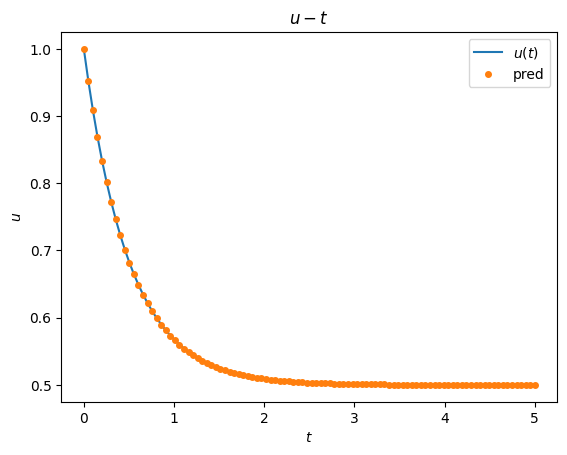

In [31]:
# visualize prediction after finished training
input_data = geom["timedomain"].uniform_points(100)
label_data = u_solution_func({"x": input_data})
output_data = solver.predict({"x": input_data})["u"].numpy()

plt.plot(input_data, label_data, "-", label=r"$u(t)$")
plt.plot(input_data, output_data, "o", label="pred", markersize=4.0)
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$u$")
plt.title(r"$u-t$")
plt.savefig("./Volterra_IDE.png", dpi=200)

## 可复用求解函数代码编写
为方便代码复用，我将原始的Volterra积分求解方程代码封装了一个统一的调用函数`build_and_solve_volterra`。
```python
def build_and_solve_volterra(kernel_func, f_func, exact_sol_func, eq_name="VolterraEq", 
                            bounds=(0, 5), npoint_interior=20, quad_deg=40):
```
此函数作为统一的求解接口接受以下参数：

- kernel_func: 核函数K(t,s)
- f_func: 非积分项函数f(t)
- exact_sol_func: 精确解函数
- eq_name: 方程标识符
- bounds: 时间域边界
- npoint_interior: 积分点数量
- quad_deg: 高斯积分阶数

### Part1. PINN模型构建
在这里，参照示例代码，我们使用3层全连接层作为求解器，输入层为时间坐标x，输出层为解函数u(x)，隐藏层设计为20神经元，激活函数采用tanh
```python
model = ppsci.arch.MLP(("x",), ("u",), 3, 20, "tanh")
```

### Part2. 计算域和方程定义
在这里，定义时间区间为计算域
```python
timedomain = ppsci.geometry.TimeDomain(*bounds)
geom = {"timedomain": timedomain}
```
定义方程右侧残差和待求解的Volterra方程
```python
def func(out):
    x, u = out["x"], out["u"]
    return u - f_func(x)

equation = {
    "volterra": ppsci.equation.Volterra(
        bounds[0], npoint_interior, quad_deg, kernel_func, func
    )
}
```


### Part3. 高斯积分点处理
提取高斯积分点并扩展输入数据
```python
def input_data_quad_transform(input, weight, label):
    x = input["x"]
    x_quad = equation["volterra"].get_quad_points(x).reshape([-1, 1])
    x_quad = paddle.concat((x, x_quad), axis=0)
    return {"x": x_quad}, weight, label

```

### Part4. 约束条件设置
这里设置两类约束，分别为积分方程约束和初值约束，分别用于强制网络满足积分方程和确保初始条件满足
```python
# 积分方程约束
ide_constraint = ppsci.constraint.InteriorConstraint(...)

# 初值约束
ic = ppsci.constraint.BoundaryConstraint(...)

# 约束集合
constraint = {
    ide_constraint.name: ide_constraint,
    ic.name: ic,
}

```

### Part5. 优化器、验证器和求解器配置
```python
optimizer = ppsci.optimizer.LBFGS(...) (model)

validator = {...}

solver = ppsci.solver.Solver(...)
```


### Part6. 模型训练
```python
solver.train()
```

### Part7. 预测与可视化
```python
input_data = timedomain.uniform_points(200)
output_data = solver.predict({"x": input_data})["u"].numpy()
label_data = exact_sol_func({"x": input_data})

plt.figure(figsize=(10, 6))
plt.plot(input_data, label_data, label="Exact", linestyle="-", linewidth=3)
plt.plot(input_data, output_data, "o", label="Predicted", markersize=6)
plt.legend(fontsize=12)
plt.xlabel("t", fontsize=14)
plt.ylabel("u(t)", fontsize=14)
plt.title(f"Solution of {eq_name}", fontsize=16)
plt.grid(True)
plt.savefig(f"{OUTPUT_DIR}/sol_{eq_name}.png", dpi=300, bbox_inches="tight")
plt.show()

```

### 求解函数代码如下所示

In [40]:
import numpy as np
import paddle
from matplotlib import pyplot as plt

import ppsci
from ppsci.autodiff import jacobian
from ppsci.utils import logger

ppsci.utils.misc.set_random_seed(42)


def build_and_solve_volterra(kernel_func, f_func, exact_sol_func, eq_name="VolterraEq", 
                            bounds=(0, 5), npoint_interior=20, quad_deg=40):
    """构建并求解沃尔泰拉积分方程
    
    Args:
        kernel_func: 核函数 K(t, s)
        f_func: 非积分项函数 f(t)
        exact_sol_func: 精确解函数
        eq_name: 方程名称标识
        bounds: 计算域边界
        npoint_interior: 内部点数量
        quad_deg: 高斯积分阶数
    """
    OUTPUT_DIR = f"./output_{eq_name}"
    logger.init_logger("ppsci", f"{OUTPUT_DIR}/train.log", "info")

    # 1. 模型构建
    model = ppsci.arch.MLP(("x",), ("u",), 3, 20, "tanh")

    # 2. 计算域构建
    timedomain = ppsci.geometry.TimeDomain(*bounds)
    geom = {"timedomain": timedomain}

    # 3. 超参数设置
    NPOINT_IC = 1
    ITERS_PER_EPOCH = 1
    EPOCHS = 1

    # 4. 方程定义
    def func(out):
        """定义方程右侧函数"""
        x, u = out["x"], out["u"]
        return u - f_func(x)

    equation = {
        "volterra": ppsci.equation.Volterra(
            bounds[0], npoint_interior, quad_deg, kernel_func, func
        )
    }

    # 5. 输入数据转换（用于高斯积分）
    def input_data_quad_transform(input, weight, label):
        x = input["x"]
        x_quad = equation["volterra"].get_quad_points(x).reshape([-1, 1])
        x_quad = paddle.concat((x, x_quad), axis=0)
        return {"x": x_quad}, weight, label

    # 6. 约束构建 - 积分方程约束
    ide_constraint = ppsci.constraint.InteriorConstraint(
        equation["volterra"].equations,
        {"volterra": 0},
        timedomain,
        {
            "dataset": {
                "name": "IterableNamedArrayDataset",
                "transforms": (
                    {
                        "FunctionalTransform": {
                            "transform_func": input_data_quad_transform,
                        },
                    },
                ),
            },
            "batch_size": npoint_interior,
            "iters_per_epoch": ITERS_PER_EPOCH,
        },
        ppsci.loss.MSELoss("mean"),
        evenly=True,
        name="EQ",
    )

    # 7. 约束构建 - 初值约束
    def u0_func(in_):
        return exact_sol_func({"x": in_["x"]})

    ic = ppsci.constraint.BoundaryConstraint(
        {"u": lambda out: out["u"]},
        {"u": u0_func},
        timedomain,
        {
            "dataset": {"name": "IterableNamedArrayDataset"},
            "batch_size": NPOINT_IC,
            "iters_per_epoch": ITERS_PER_EPOCH,
        },
        ppsci.loss.MSELoss("mean"),
        criteria=timedomain.on_initial,
        name="IC",
    )

    constraint = {
        ide_constraint.name: ide_constraint,
        ic.name: ic,
    }

    # 8. 优化器构建
    optimizer = ppsci.optimizer.LBFGS(
        learning_rate=1,
        max_iter=15000,
        max_eval=1250,
        tolerance_grad=1e-8,
        tolerance_change=0,
        history_size=100,
    )(model)

    # 9. 评估器构建
    validator = {
        "L2Rel_Validator": ppsci.validate.GeometryValidator(
            {"u": lambda out: out["u"]},
            {"u": exact_sol_func},
            timedomain,
            {
                "dataset": "IterableNamedArrayDataset",
                "total_size": 200,
            },
            ppsci.loss.L2RelLoss(),
            evenly=True,
            metric={"L2Rel": ppsci.metric.L2Rel()},
            name="L2Rel_Validator",
        )
    }

    # 10. 求解器构建
    solver = ppsci.solver.Solver(
        model,
        constraint,
        OUTPUT_DIR,
        optimizer,
        epochs=EPOCHS,
        iters_per_epoch=ITERS_PER_EPOCH,
        eval_during_train=True,
        eval_freq=1,
        equation=equation,
        geom=geom,
        validator=validator,
        eval_with_no_grad=True,
    )

    # 11. 模型训练
    solver.train()

    # 12. 结果可视化
    input_data = timedomain.uniform_points(200)
    output_data = solver.predict({"x": input_data})["u"].numpy()
    label_data = exact_sol_func({"x": input_data})

    plt.figure(figsize=(10, 6))
    plt.plot(input_data, label_data, label="Exact", linestyle="-", linewidth=3)
    plt.plot(input_data, output_data, "o", label="Predicted", markersize=6)
    plt.legend(fontsize=12)
    plt.xlabel("t", fontsize=14)
    plt.ylabel("u(t)", fontsize=14)
    plt.title(f"Solution of {eq_name}", fontsize=16)
    plt.grid(True)
    plt.savefig(f"{OUTPUT_DIR}/sol_{eq_name}.png", dpi=300, bbox_inches="tight")
    plt.show()












## 示例求解
我们选取了四个Volterra方程求解，来验证该函数的正确性和实用性

### 示例 A：卷积型 Volterra 方程（官方示例的变体）

首先，为了验证编写函数的正确性，我们使用该函数，对官方给出的同一示例进行了测试

该 Volterra 积分方程为：

$$
u(t) = -\frac{du}{dt} + \int_0^t e^{s - t} \, u(s) \, ds
$$


In [41]:
# ------------------------
# 示例 A：官方示例的变体
# 方程: u(t) = -du/dt + ∫₀ᵗ e^{s-t} u(s) ds
# 精确解: u(t) = e^{-t} cosh(t)
# ------------------------
def solve_volterra_eq_A():
    """官方示例的变体"""
    def kernel_func(t, s):
        return np.exp(s - t)
    
    def f_func(t):
        # 精确解的导数
        if isinstance(t, paddle.Tensor):
            return -(-paddle.exp(-t) * paddle.cosh(t) + paddle.exp(-t) * paddle.sinh(t))
        else:
            return -(-np.exp(-t) * np.cosh(t) + np.exp(-t) * np.sinh(t))
    
    def exact_sol(in_):
        x = in_["x"]
        if isinstance(x, paddle.Tensor):
            return paddle.exp(-x) * paddle.cosh(x)
        else:
            return np.exp(-x) * np.cosh(x)
    
    build_and_solve_volterra(kernel_func, f_func, exact_sol, 
                           eq_name="Volterra_Example_A",
                           bounds=(0, 5),
                           npoint_interior=20,
                           quad_deg=40)

[2025/06/09 16:40:53] ppsci INFO: Using paddlepaddle develop(f41f081) on device Place(gpu:0)
[2025/06/09 16:40:53] ppsci MESSAGE: Set to_static=False for computational optimization.
[2025/06/09 16:40:54] ppsci INFO: [Train][Epoch 1/1][Iter 1/1] lr: 1.00000, loss: 0.00000, EQ: 0.00000, IC: 0.00000, batch_cost: 1.06819s, reader_cost: 0.00044s, ips: 768.59, eta: 0:00:00
[2025/06/09 16:40:54] ppsci INFO: [Eval][Epoch 1/1][Iter 1/1] L2Rel_Validator/loss: 0.00029, batch_cost: 0.00081s, reader_cost: 0.00001s, ips: 247378.59, eta: 0:00:00
[2025/06/09 16:40:54] ppsci INFO: [Eval][Epoch 1][Avg] L2Rel_Validator/loss: 0.00029, L2Rel_Validator/L2Rel.u: 0.00042
[2025/06/09 16:40:54] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_A/checkpoints/best_model
[2025/06/09 16:40:54] ppsci INFO: [Eval][Epoch 1][best metric: 0.00041789707029238343]
[2025/06/09 16:40:54] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_A/checkpoints/latest(latest checkpoint will be s

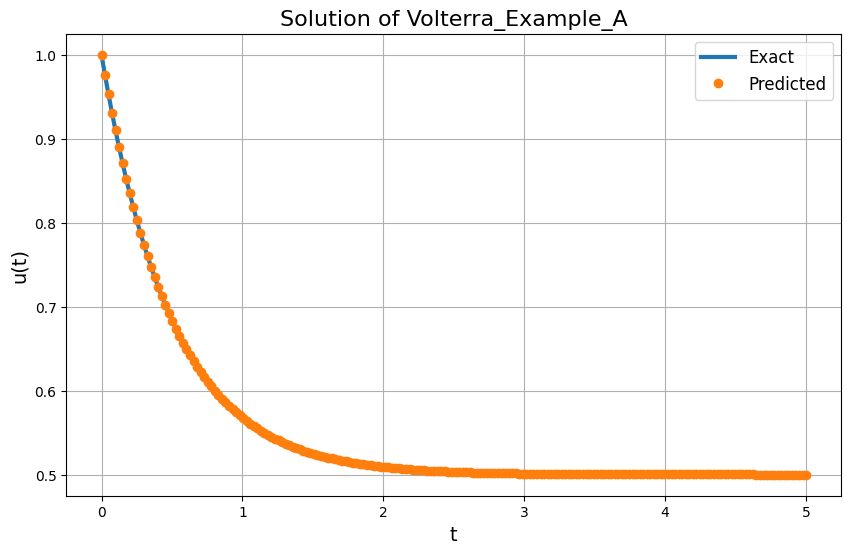

In [42]:
solve_volterra_eq_A()

从该示例结果看出，我们重构后的调用函数可以给出正确的结果

### 示例 B：卷积型 Volterra 方程（多项式方程）

## 方程形式

本例研究的 Volterra 积分方程为：

$$
u(t) = t^3 + \int_0^t (t - s) \, u(s) \, ds
$$

这是一个典型的线性卷积型 Volterra 方程，具有简单的多项式结构，方便用于测试基本求解器的性能。


* **核函数：** \$K(t, s) = t - s\$，这是一个随时间差线性增长的核函数，表示越靠近当前时刻的历史信息对当前状态的影响越强。
* **右侧函数：** \$f(t) = t^3\$，一个简单的三次多项式，是问题的驱动项。
* **精确解：** \$u(t) = t^3 + \frac{t^4}{4}\$，解析解为多项式形式，可以用于验证数值解的准确性。

参数设计

* **积分区间：** 选取 \$t \in \[0, 2]\$，这是一个较短时间区间，方便观察解在初期的发展情况，同时避免多项式爆炸导致数值不稳定。
* **积分点数：** 选取 15 个内部积分点，因为这是一个多项式问题，函数变化较平缓，点数不宜过多，兼顾训练效率。
* **高斯积分阶数：** 选取 30 阶 Gauss-Legendre 积分，足以保证积分精度，同时控制计算量。

* 调用 `build_and_solve_volterra`：统一封装数据生成、神经网络训练、积分计算与结果验证流程。
* 设置参数：

  * `eq_name="Volterra_Example_B"`：用于命名和结果文件管理。
  * `bounds=(0, 2)`：设置时间区间。
  * `npoint_interior=15`：控制训练点数。
  * `quad_deg=30`：设置高斯积分阶数，兼顾速度与精度。



In [43]:
# ------------------------
# 示例 B：多项式方程
# 方程: u(t) = t^3 + ∫₀ᵗ (t-s) * u(s) ds
# 精确解: u(t) = t^3 + t^4/4
# ------------------------
def solve_volterra_eq_B():
    """多项式方程"""
    def kernel_func(t, s):
        return t - s
    
    def f_func(t):
        if isinstance(t, paddle.Tensor):
            return t**3
        else:
            return t**3
    
    def exact_sol(in_):
        x = in_["x"]
        if isinstance(x, paddle.Tensor):
            return x**3 + x**4/4
        else:
            return x**3 + x**4/4
    
    build_and_solve_volterra(kernel_func, f_func, exact_sol, 
                           eq_name="Volterra_Example_B",
                           bounds=(0, 2),
                           npoint_interior=15,
                           quad_deg=30)


[2025/06/09 16:44:17] ppsci INFO: Using paddlepaddle develop(f41f081) on device Place(gpu:0)
[2025/06/09 16:44:17] ppsci MESSAGE: Set to_static=False for computational optimization.
[2025/06/09 16:44:18] ppsci INFO: [Train][Epoch 1/1][Iter 1/1] lr: 1.00000, loss: 0.00001, EQ: 0.00001, IC: 0.00000, batch_cost: 1.45316s, reader_cost: 0.00056s, ips: 320.68, eta: 0:00:00
[2025/06/09 16:44:18] ppsci INFO: [Eval][Epoch 1/1][Iter 1/1] L2Rel_Validator/loss: inf, batch_cost: 0.00109s, reader_cost: 0.00001s, ips: 184157.58, eta: 0:00:00
[2025/06/09 16:44:18] ppsci INFO: [Eval][Epoch 1][Avg] L2Rel_Validator/loss: inf, L2Rel_Validator/L2Rel.u: 0.18752
[2025/06/09 16:44:18] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_B/checkpoints/best_model
[2025/06/09 16:44:18] ppsci INFO: [Eval][Epoch 1][best metric: 0.1875220537185669]
[2025/06/09 16:44:18] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_B/checkpoints/latest(latest checkpoint will be saved every e

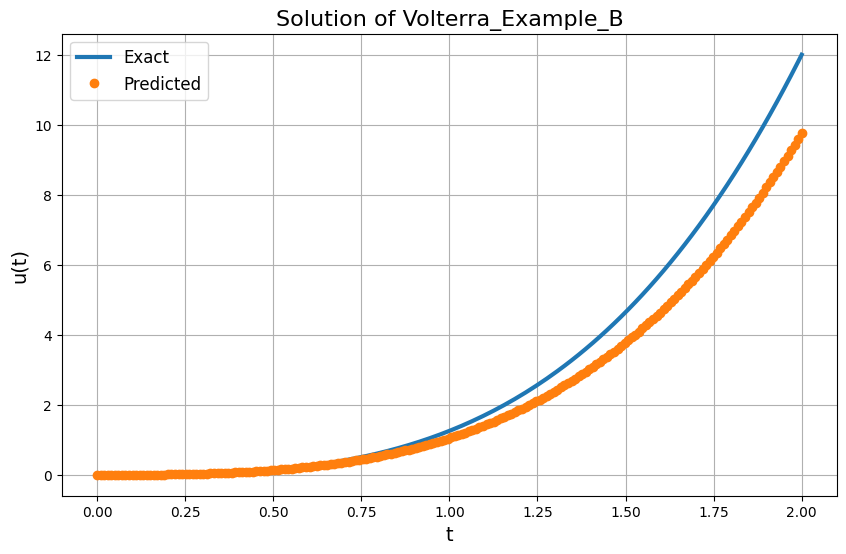

In [44]:
solve_volterra_eq_B()

从结果可以看到，预测值与真值大致符合。

### 示例 C：卷积型 Volterra 方程（指数方程）


本例研究的 Volterra 积分方程为：

$$
u(t) = e^{-t^2} + \int_0^t e^{s^2 - t^2} \, u(s) \, ds
$$

这是一个具有非线性指数核的卷积型 Volterra 方程，测试数值积分在复杂核函数下的表现。

* **核函数：** \$K(t, s) = e^{s^2 - t^2}\$，呈现非对称指数增长/衰减形式，历史项随着时间距离的变化对当前状态的影响呈指数变化。
* **右侧函数：** \$f(t) = e^{-t^2}\$，是一个快速衰减的高斯型函数，驱动项在 \$t\$ 增大时迅速趋近于零。
* **精确解：** \$u(t) = e^{-t^2}\$，解析解与右侧项完全相同，积分项与解本身完美抵消，这一特性为验证数值解提供了良好的基础。

参数设置

* **积分区间：** 选取 \$t \in \[0, 3]\$，这是高斯函数主要变化的区间，超过 3 时高斯项已经非常接近零，积分贡献较小。
* **积分点数：** 选取 18 个内部积分点，因为指数核函数变化较快，相比多项式方程需要更多的离散点以捕捉精细结构。
* **高斯积分阶数：** 选取 40 阶 Gauss-Legendre 积分，以保证在快速变化的指数函数下仍能获得较高的积分精度。



In [47]:
# ------------------------
# 示例 C：指数方程
# 方程: u(t) = e^{-t^2} + ∫₀ᵗ e^{s^2-t^2} u(s) ds
# 精确解: u(t) = e^{-t^2}
# ------------------------
def solve_volterra_eq_C():
    """指数方程"""
    def kernel_func(t, s):
        return np.exp(s**2 - t**2)
    
    def f_func(t):
        if isinstance(t, paddle.Tensor):
            return paddle.exp(-t**2)
        else:
            return np.exp(-t**2)
    
    def exact_sol(in_):
        x = in_["x"]
        if isinstance(x, paddle.Tensor):
            return paddle.exp(-x**2)
        else:
            return np.exp(-x**2)
    
    build_and_solve_volterra(kernel_func, f_func, exact_sol, 
                           eq_name="Volterra_Example_C",
                           bounds=(0, 3),
                           npoint_interior=18,
                           quad_deg=40)


[2025/06/09 16:47:29] ppsci INFO: Using paddlepaddle develop(f41f081) on device Place(gpu:0)
[2025/06/09 16:47:29] ppsci MESSAGE: Set to_static=False for computational optimization.
[2025/06/09 16:47:33] ppsci INFO: [Train][Epoch 1/1][Iter 1/1] lr: 1.00000, loss: 0.00000, EQ: 0.00000, IC: 0.00000, batch_cost: 4.41254s, reader_cost: 0.00068s, ips: 167.48, eta: 0:00:00
[2025/06/09 16:47:33] ppsci INFO: [Eval][Epoch 1/1][Iter 1/1] L2Rel_Validator/loss: 5.36266, batch_cost: 0.00114s, reader_cost: 0.00001s, ips: 176191.93, eta: 0:00:00
[2025/06/09 16:47:33] ppsci INFO: [Eval][Epoch 1][Avg] L2Rel_Validator/loss: 5.36266, L2Rel_Validator/L2Rel.u: 0.79528
[2025/06/09 16:47:33] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_C/checkpoints/best_model
[2025/06/09 16:47:33] ppsci INFO: [Eval][Epoch 1][best metric: 0.7952754497528076]
[2025/06/09 16:47:33] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_C/checkpoints/latest(latest checkpoint will be saved

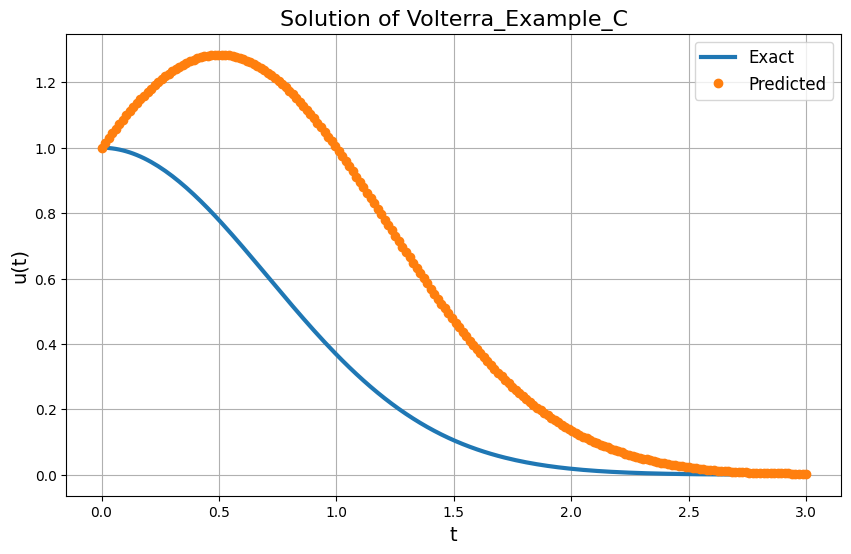

In [48]:
solve_volterra_eq_C()

该例效果并无之前两例好，但整体趋势较为相符

### 示例 D：三角函数型 Volterra 方程解析

本例研究的 Volterra 积分方程为：

$$
u(t) = \sin(t) + \int_0^t \cos(t - s) \, u(s) \, ds
$$

该方程属于第一类 Volterra 积分方程，核函数 \$K(t, s)\$ 与被积函数 \$u(s)\$ 存在线性卷积关系。


* **核函数：** \$K(t, s) = \cos(t - s)\$，这是一个具有卷积性质的核函数，物理上可理解为某种记忆效应或延迟响应。
* **右侧函数：** \$f(t) = \sin(t)\$，这是外部强迫项，给出了系统的初始输入。
* **精确解：** \$u(t) = \sin(t) + \frac{t \sin(t)}{2}\$，解析解可验证该问题的数值解的正确性。

参数设计：

* **积分区间：** 选取 \$t \in \[0, 4]\$，该区间可覆盖完整的一个三角函数周期，便于观察解在完整周期内的行为。
* **积分点数：** 选取 25 个内部积分点，平衡了计算精度与训练速度。点数过少会导致高斯积分不准确，点数过多会增加计算负担。
* **高斯积分阶数：** 选取 50 阶 Gauss-Legendre 积分，以确保卷积型核函数积分的数值精度。因为核函数为 \$\cos(t - s)\$，在积分区间内可能震荡较快，因此需要更高的积分精度。





In [36]:
# ------------------------
# 示例 D：三角函数方程
# 方程: u(t) = sin(t) + ∫₀ᵗ cos(t-s) u(s) ds
# 精确解: u(t) = sin(t) + t*sin(t)/2
# ------------------------
def solve_volterra_eq_D():
    """三角函数方程"""
    def kernel_func(t, s):
        return np.cos(t - s)
    
    def f_func(t):
        if isinstance(t, paddle.Tensor):
            return paddle.sin(t)
        else:
            return np.sin(t)
    
    def exact_sol(in_):
        x = in_["x"]
        if isinstance(x, paddle.Tensor):
            return paddle.sin(x) + x * paddle.sin(x) / 2
        else:
            return np.sin(x) + x * np.sin(x) / 2
    
    build_and_solve_volterra(kernel_func, f_func, exact_sol, 
                           eq_name="Volterra_Example_D",
                           bounds=(0, 4),
                           npoint_interior=25,
                           quad_deg=50)



[2025/06/09 16:45:05] ppsci INFO: Using paddlepaddle develop(f41f081) on device Place(gpu:0)
[2025/06/09 16:45:05] ppsci MESSAGE: Set to_static=False for computational optimization.
[2025/06/09 16:45:10] ppsci INFO: [Train][Epoch 1/1][Iter 1/1] lr: 1.00000, loss: 0.00000, EQ: 0.00000, IC: 0.00000, batch_cost: 5.17834s, reader_cost: 0.00061s, ips: 246.41, eta: 0:00:00
[2025/06/09 16:45:10] ppsci INFO: [Eval][Epoch 1/1][Iter 1/1] L2Rel_Validator/loss: inf, batch_cost: 0.00110s, reader_cost: 0.00001s, ips: 182254.56, eta: 0:00:00
[2025/06/09 16:45:10] ppsci INFO: [Eval][Epoch 1][Avg] L2Rel_Validator/loss: inf, L2Rel_Validator/L2Rel.u: 1.03261
[2025/06/09 16:45:10] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_D/checkpoints/best_model
[2025/06/09 16:45:10] ppsci INFO: [Eval][Epoch 1][best metric: 1.0326108932495117]
[2025/06/09 16:45:10] ppsci MESSAGE: Finish saving checkpoint to: ./output_Volterra_Example_D/checkpoints/latest(latest checkpoint will be saved every e

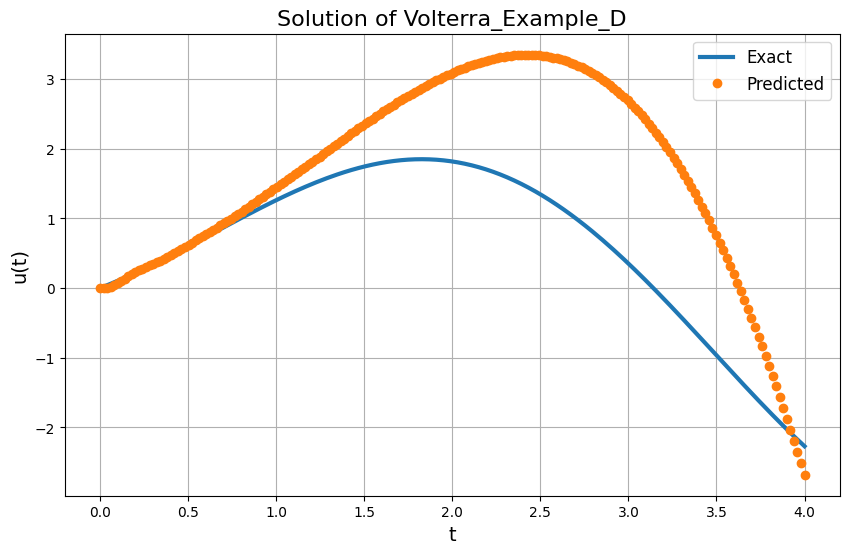

In [46]:
solve_volterra_eq_D()

## 6. 参考文献

- [DeepXDE - Volterra_IDE](https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/Volterra_IDE.py)
- [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature#Change_of_interval)
- [Volterra integral equation](https://en.wikipedia.org/wiki/Volterra_integral_equation)
